In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load accepted loans data
accepted_df = pd.read_csv('accepted_2007_to_2018Q4.csv')
accepted_df['loan_status_label'] = 1  # 1 for accepted

# Load rejected loans data
rejected_df = pd.read_csv('rejected_2007_to_2018Q4.csv')
rejected_df['loan_status_label'] = 0  # 0 for rejected

print(f"Accepted Loans Shape: {accepted_df.shape}")
print(f"Rejected Loans Shape: {rejected_df.shape}")
print("\nAccepted Loans Columns:", accepted_df.columns.tolist()[:10], "...")
print("\nRejected Loans Columns:", rejected_df.columns.tolist())

Accepted Loans Shape: (2260701, 152)
Rejected Loans Shape: (27648741, 10)

Accepted Loans Columns: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade'] ...

Rejected Loans Columns: ['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score', 'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length', 'Policy Code', 'loan_status_label']


In [3]:

# Map common features between datasets
feature_mapping = {
    'accepted': {
        'loan_amnt': 'Amount Requested',
        'int_rate': 'Risk_Score',
        'dti': 'Debt-To-Income Ratio',
        'zip_code': 'Zip Code',
        'addr_state': 'State',
        'emp_length': 'Employment Length',
        'policy_code': 'Policy Code'
    }
}

# Create unified dataset with common features
accepted_common = pd.DataFrame()
accepted_common['amount_requested'] = accepted_df['loan_amnt']
accepted_common['risk_score'] = accepted_df['fico_range_low']  # Using FICO as risk indicator
accepted_common['dti'] = accepted_df['dti']
accepted_common['zip_code'] = accepted_df['zip_code']
accepted_common['state'] = accepted_df['addr_state']
accepted_common['emp_length'] = accepted_df['emp_length']
accepted_common['annual_inc'] = accepted_df['annual_inc']
accepted_common['loan_status'] = 1

rejected_common = pd.DataFrame()
rejected_common['amount_requested'] = rejected_df['Amount Requested']
rejected_common['risk_score'] = rejected_df['Risk_Score']
rejected_common['dti'] = rejected_df['Debt-To-Income Ratio']
rejected_common['zip_code'] = rejected_df['Zip Code']
rejected_common['state'] = rejected_df['State']
rejected_common['emp_length'] = rejected_df['Employment Length']
rejected_common['annual_inc'] = np.nan  # Not available in rejected data
rejected_common['loan_status'] = 0

# Combine datasets
combined_df = pd.concat([accepted_common, rejected_common], ignore_index=True)

print(f"\nCombined Dataset Shape: {combined_df.shape}")
print("\nFirst few rows:")
print(combined_df.head())


Combined Dataset Shape: (29909442, 8)

First few rows:
   amount_requested  risk_score    dti zip_code state emp_length  annual_inc  \
0            3600.0       675.0   5.91    190xx    PA  10+ years     55000.0   
1           24700.0       715.0  16.06    577xx    SD  10+ years     65000.0   
2           20000.0       695.0  10.78    605xx    IL  10+ years     63000.0   
3           35000.0       785.0  17.06    076xx    NJ  10+ years    110000.0   
4           10400.0       695.0  25.37    174xx    PA    3 years    104433.0   

   loan_status  
0            1  
1            1  
2            1  
3            1  
4            1  


MISSING VALUES ANALYSIS
                            Column  Missing_Count  Missing_Percentage
annual_inc              annual_inc       27648778           92.441638
risk_score              risk_score       18497663           61.845564
emp_length              emp_length        1098295            3.672068
dti                            dti           1744            0.005831
zip_code                  zip_code            327            0.001093
state                        state             55            0.000184
amount_requested  amount_requested             33            0.000110


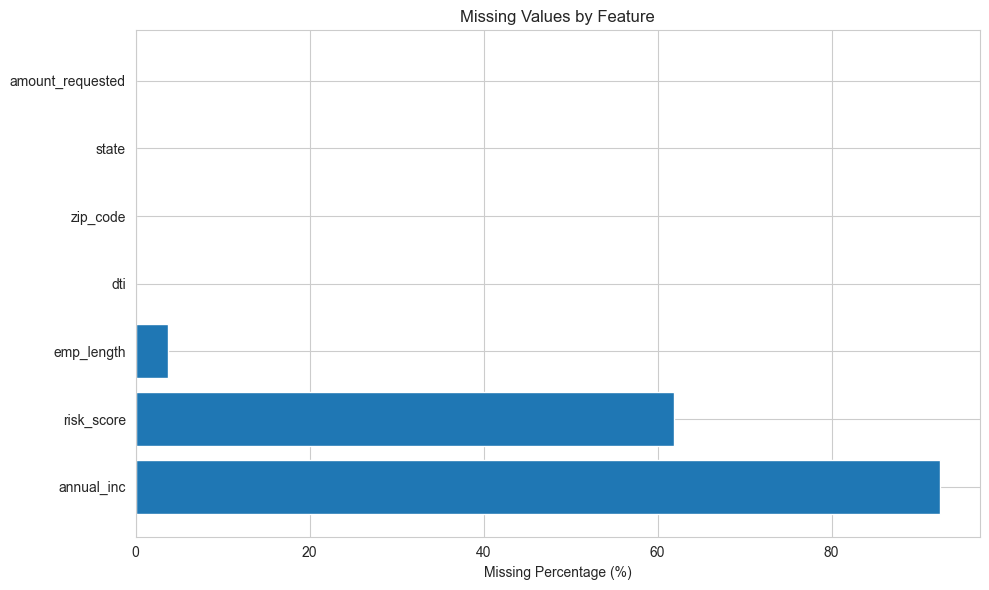

In [4]:
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing_data = pd.DataFrame({
    'Column': combined_df.columns,
    'Missing_Count': combined_df.isnull().sum(),
    'Missing_Percentage': (combined_df.isnull().sum() / len(combined_df)) * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_data)

# Visualize missing data
plt.figure(figsize=(10, 6))
plt.barh(missing_data['Column'], missing_data['Missing_Percentage'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Values by Feature')
plt.tight_layout()
plt.show()


TARGET VARIABLE DISTRIBUTION

Loan Status Distribution:
Accepted (1): 2260701 (7.56%)
Rejected (0): 27648741 (92.44%)


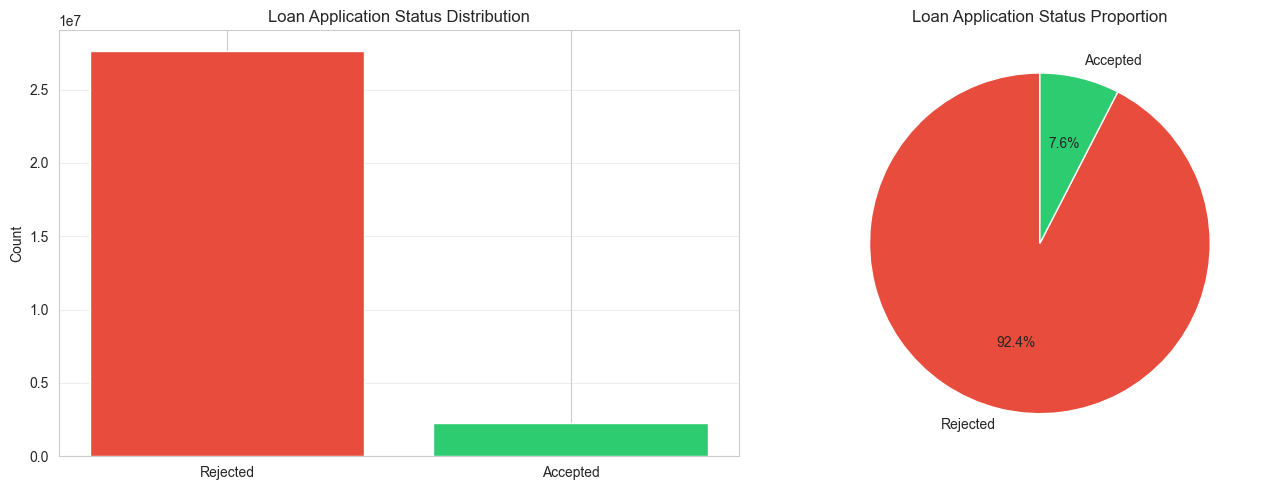

In [5]:
print("\n" + "=" * 80)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 80)

target_counts = combined_df['loan_status'].value_counts()
print(f"\nLoan Status Distribution:")
print(f"Accepted (1): {target_counts[1]} ({target_counts[1]/len(combined_df)*100:.2f}%)")
print(f"Rejected (0): {target_counts[0]} ({target_counts[0]/len(combined_df)*100:.2f}%)")

# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Rejected', 'Accepted'], target_counts.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Loan Application Status Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(target_counts.values, labels=['Rejected', 'Accepted'], 
           autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'], startangle=90)
axes[1].set_title('Loan Application Status Proportion')

plt.tight_layout()
plt.show()


CATEGORICAL FEATURES ANALYSIS


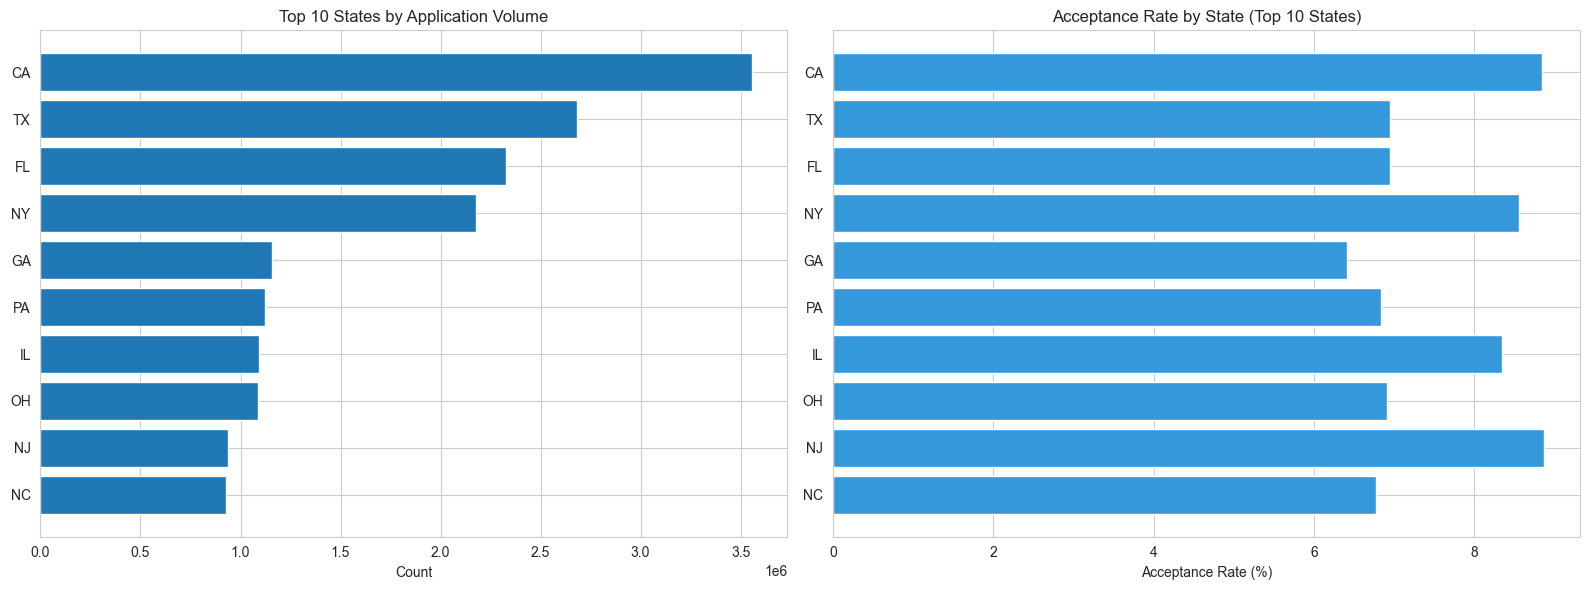

In [9]:
print("\n" + "=" * 80)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 80)

# State distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 states
top_states = combined_df['state'].value_counts().head(10)
axes[0].barh(top_states.index, top_states.values)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 10 States by Application Volume')
axes[0].invert_yaxis()

# Acceptance rate by state
state_acceptance = combined_df.groupby('state')['loan_status'].agg(['sum', 'count'])
state_acceptance['rate'] = (state_acceptance['sum'] / state_acceptance['count'] * 100)
top_states_acceptance = state_acceptance.nlargest(10, 'count')

axes[1].barh(top_states_acceptance.index, top_states_acceptance['rate'], color='#3498db')
axes[1].set_xlabel('Acceptance Rate (%)')
axes[1].set_title('Acceptance Rate by State (Top 10 States)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

Correlation Matrix:
                  amount_requested  risk_score       dti  annual_inc  \
amount_requested          1.000000    0.110466  0.043540    0.197635   
risk_score                0.110466    1.000000 -0.027923    0.037230   
dti                       0.043540   -0.027923  1.000000   -0.082619   
annual_inc                0.197635    0.037230 -0.082619    1.000000   
loan_status                    NaN         NaN       NaN         NaN   

                  loan_status  
amount_requested          NaN  
risk_score                NaN  
dti                       NaN  
annual_inc                NaN  
loan_status               NaN  


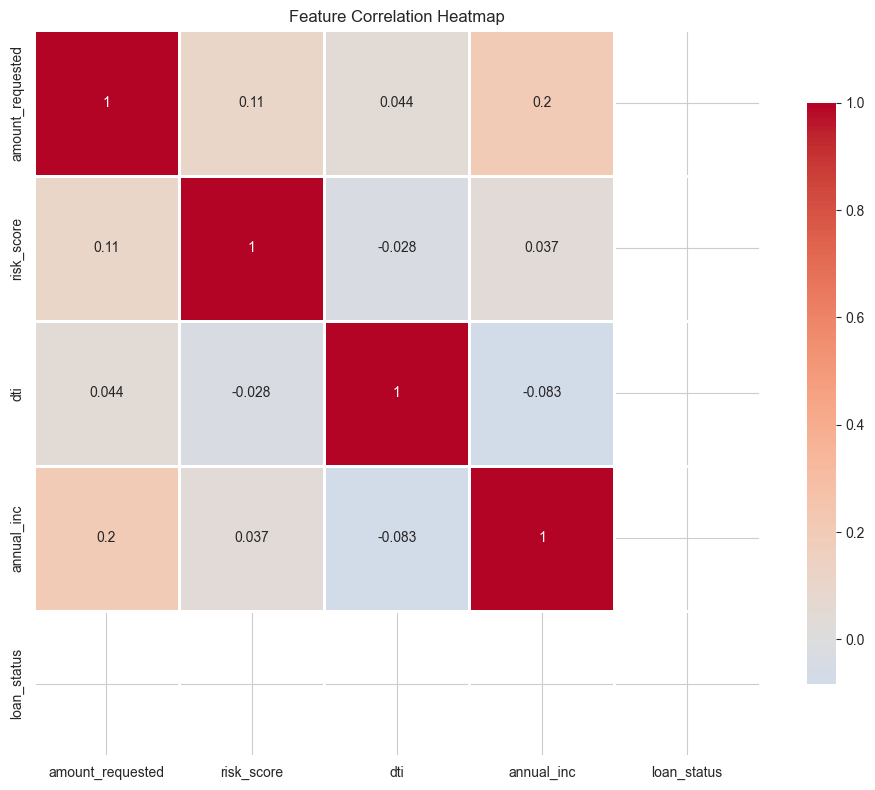

In [10]:
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical columns for correlation
corr_cols = ['amount_requested', 'risk_score', 'dti', 'annual_inc', 'loan_status']
corr_df = combined_df[corr_cols].dropna()

correlation_matrix = corr_df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


DETAILED LOAN AMOUNT ANALYSIS


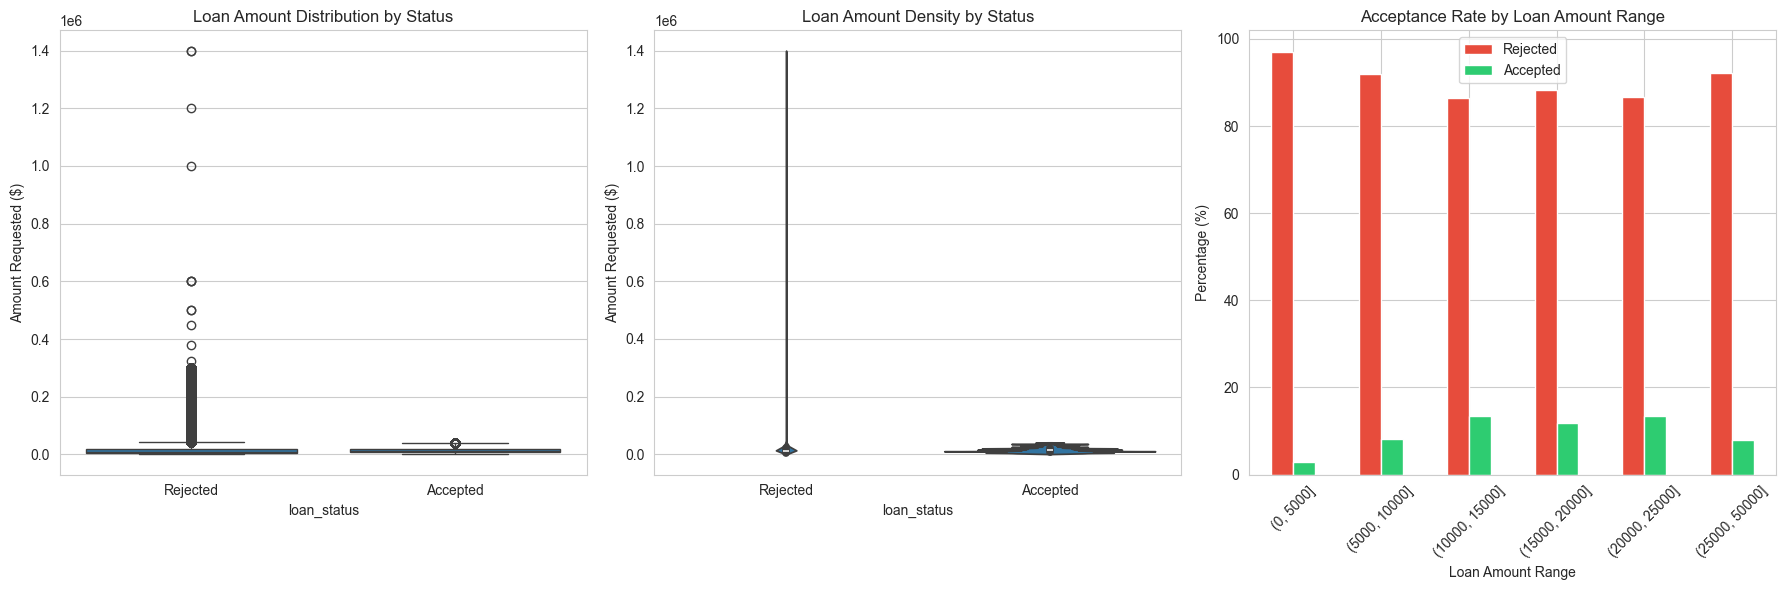


Loan Amount Statistics by Status:
                  count          mean           std    min     25%      50%  \
loan_status                                                                   
0            27648741.0  13133.240309  15009.636324    0.0  4800.0  10000.0   
1             2260668.0  15046.931228   9190.245488  500.0  8000.0  12900.0   

                 75%        max  
loan_status                      
0            20000.0  1400000.0  
1            20000.0    40000.0  


In [11]:
print("\n" + "=" * 80)
print("DETAILED LOAN AMOUNT ANALYSIS")
print("=" * 80)

# Box plots for loan amount
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot
sns.boxplot(x='loan_status', y='amount_requested', data=combined_df, ax=axes[0])
axes[0].set_xticklabels(['Rejected', 'Accepted'])
axes[0].set_title('Loan Amount Distribution by Status')
axes[0].set_ylabel('Amount Requested ($)')

# Violin plot
sns.violinplot(x='loan_status', y='amount_requested', data=combined_df, ax=axes[1])
axes[1].set_xticklabels(['Rejected', 'Accepted'])
axes[1].set_title('Loan Amount Density by Status')
axes[1].set_ylabel('Amount Requested ($)')

# Amount ranges
amount_bins = [0, 5000, 10000, 15000, 20000, 25000, 50000]
combined_df['amount_range'] = pd.cut(combined_df['amount_requested'], bins=amount_bins)
amount_status = pd.crosstab(combined_df['amount_range'], combined_df['loan_status'], normalize='index') * 100
amount_status.plot(kind='bar', ax=axes[2], color=['#e74c3c', '#2ecc71'])
axes[2].set_title('Acceptance Rate by Loan Amount Range')
axes[2].set_xlabel('Loan Amount Range')
axes[2].set_ylabel('Percentage (%)')
axes[2].legend(['Rejected', 'Accepted'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nLoan Amount Statistics by Status:")
print(combined_df.groupby('loan_status')['amount_requested'].describe())



RISK SCORE DEEP DIVE


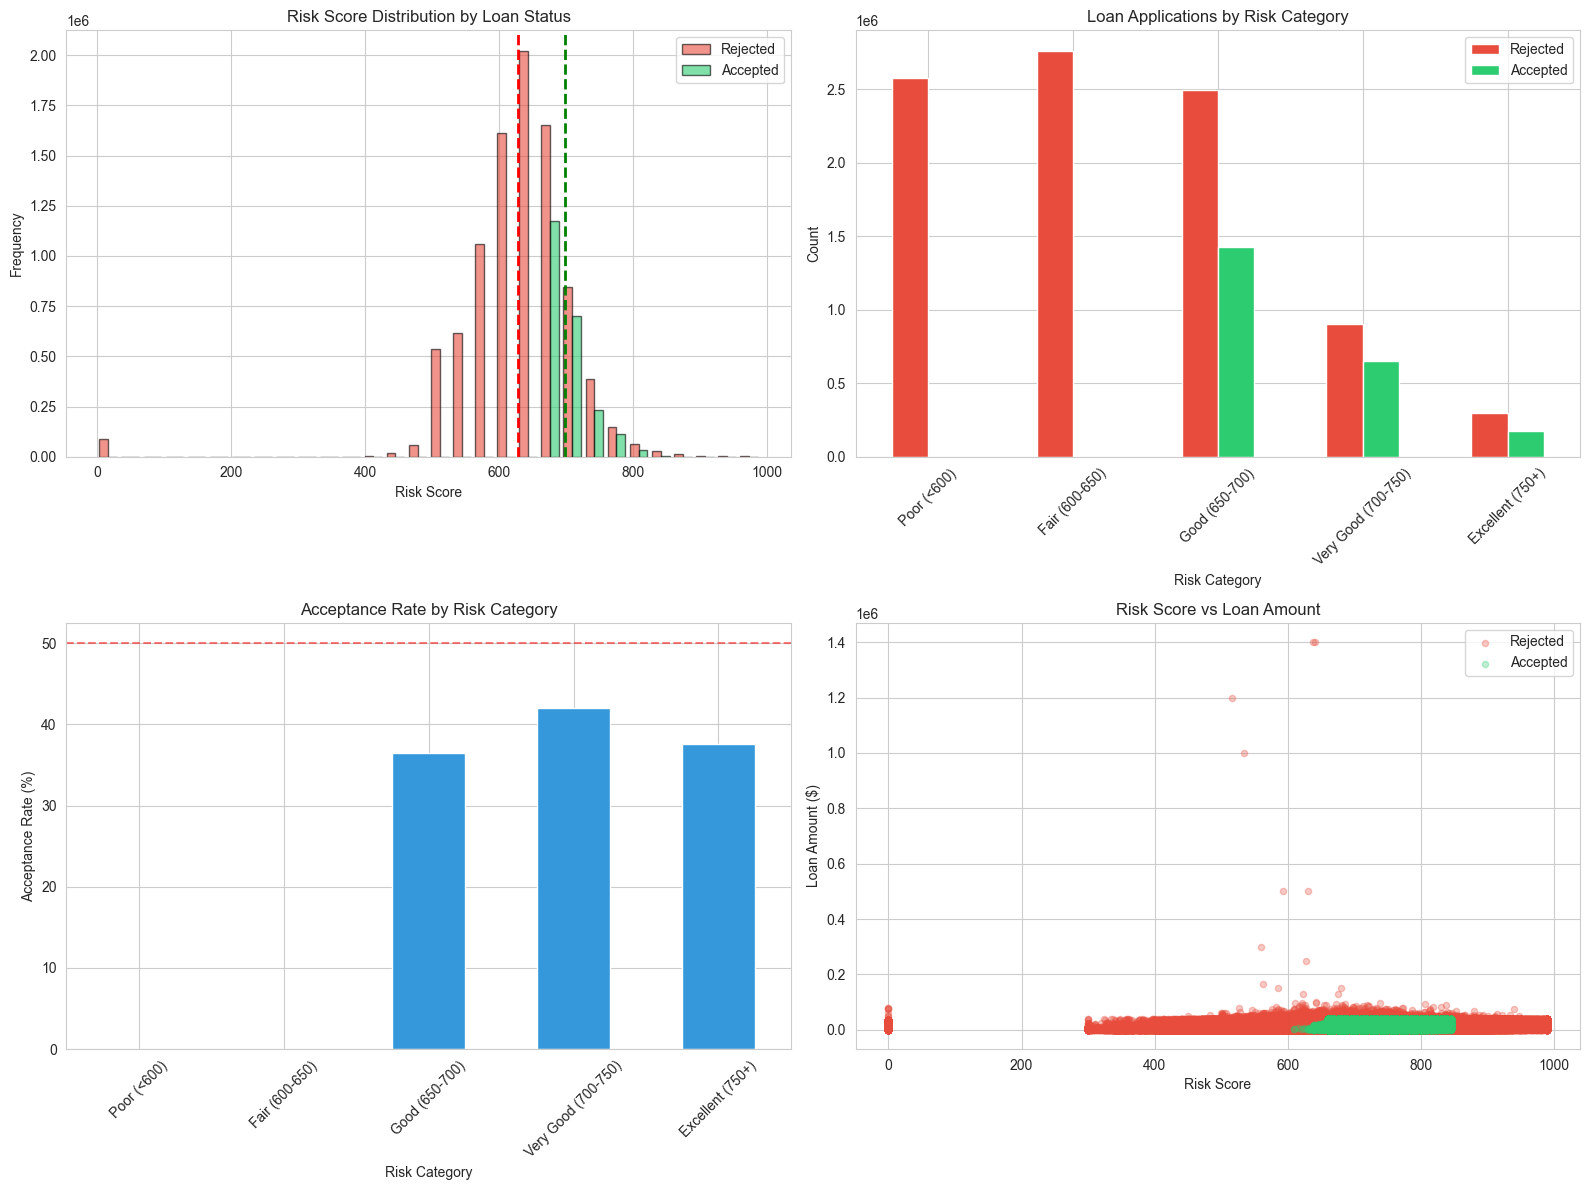


Risk Score Statistics:
                 count        mean        std    min    25%    50%    75%  \
loan_status                                                                 
0            9151111.0  628.172090  89.936793    0.0  591.0  637.0  675.0   
1            2260668.0  698.588205  33.010376  610.0  675.0  690.0  715.0   

               max  
loan_status         
0            990.0  
1            845.0  

DEBT-TO-INCOME RATIO ANALYSIS


KeyError: 1

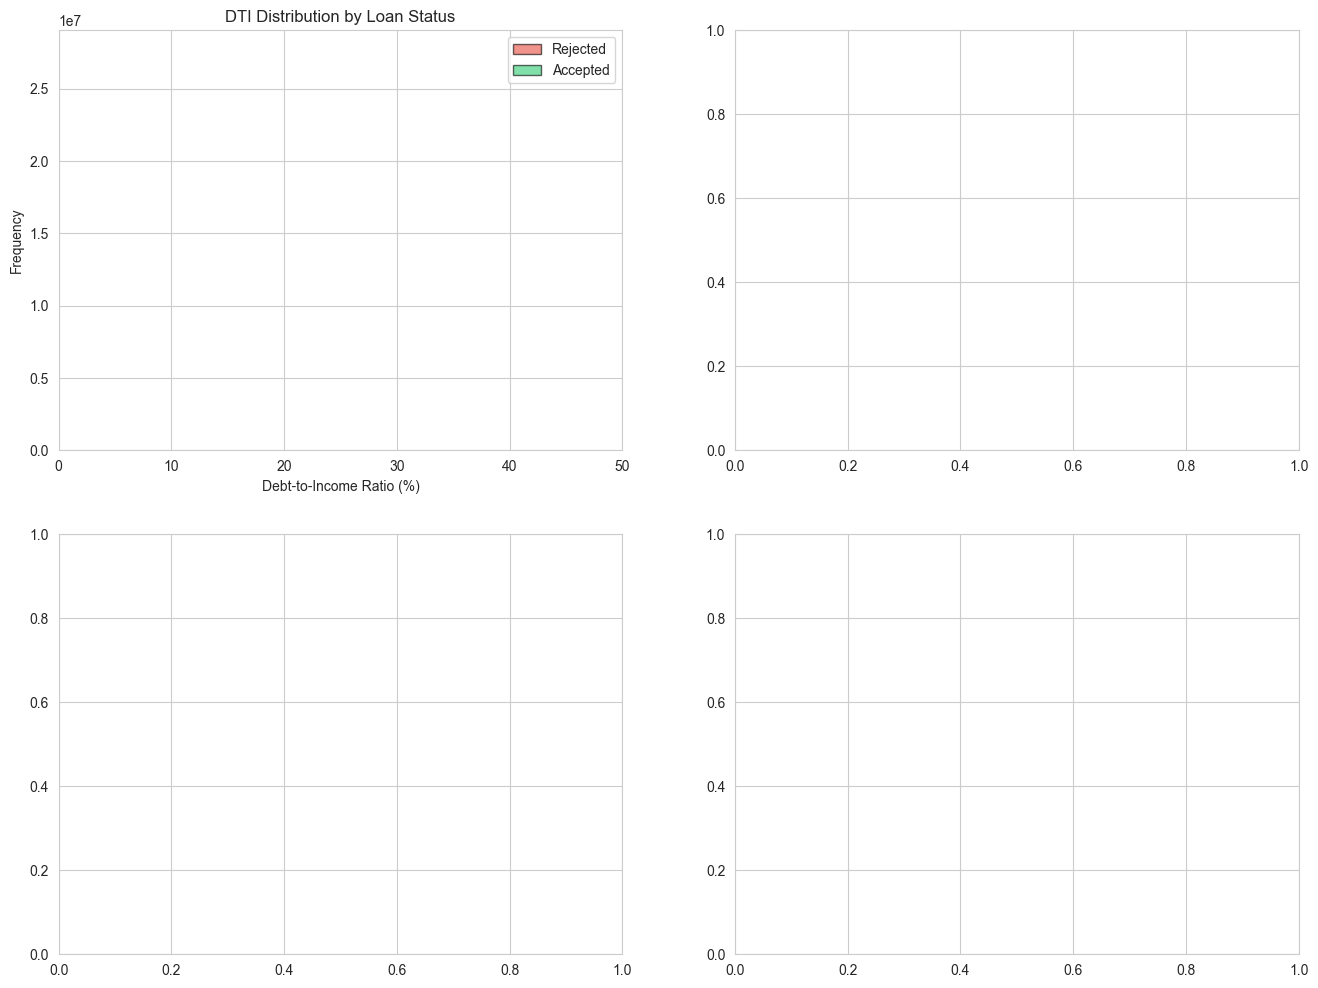

In [ ]:
print("\n" + "=" * 80)
print("RISK SCORE DEEP DIVE")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk score distribution by status
axes[0, 0].hist([combined_df[combined_df['loan_status']==0]['risk_score'].dropna(),
                 combined_df[combined_df['loan_status']==1]['risk_score'].dropna()],
                bins=30, label=['Rejected', 'Accepted'], color=['#e74c3c', '#2ecc71'], 
                alpha=0.6, edgecolor='black')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Risk Score Distribution by Loan Status')
axes[0, 0].legend()
axes[0, 0].axvline(combined_df[combined_df['loan_status']==1]['risk_score'].mean(), 
                   color='green', linestyle='--', linewidth=2, label='Accepted Mean')
axes[0, 0].axvline(combined_df[combined_df['loan_status']==0]['risk_score'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Rejected Mean')

# Risk score ranges
risk_bins = [0, 600, 650, 700, 750, 850]
risk_labels = ['Poor (<600)', 'Fair (600-650)', 'Good (650-700)', 'Very Good (700-750)', 'Excellent (750+)']
combined_df['risk_category'] = pd.cut(combined_df['risk_score'], bins=risk_bins, labels=risk_labels)

risk_counts = combined_df.groupby(['risk_category', 'loan_status']).size().unstack(fill_value=0)
risk_counts.plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#2ecc71'])
axes[0, 1].set_title('Loan Applications by Risk Category')
axes[0, 1].set_xlabel('Risk Category')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['Rejected', 'Accepted'])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Acceptance rate by risk category
risk_acceptance = pd.crosstab(combined_df['risk_category'], combined_df['loan_status'], normalize='index') * 100
risk_acceptance[1].plot(kind='bar', ax=axes[1, 0], color='#3498db')
axes[1, 0].set_title('Acceptance Rate by Risk Category')
axes[1, 0].set_xlabel('Risk Category')
axes[1, 0].set_ylabel('Acceptance Rate (%)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
axes[1, 0].axhline(50, color='red', linestyle='--', alpha=0.5)

# Risk score vs loan amount scatter
accepted = combined_df[combined_df['loan_status']==1]
rejected = combined_df[combined_df['loan_status']==0]
axes[1, 1].scatter(rejected['risk_score'], rejected['amount_requested'], 
                   alpha=0.3, s=20, c='#e74c3c', label='Rejected')
axes[1, 1].scatter(accepted['risk_score'], accepted['amount_requested'], 
                   alpha=0.3, s=20, c='#2ecc71', label='Accepted')
axes[1, 1].set_xlabel('Risk Score')
axes[1, 1].set_ylabel('Loan Amount ($)')
axes[1, 1].set_title('Risk Score vs Loan Amount')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nRisk Score Statistics:")
print(combined_df.groupby('loan_status')['risk_score'].describe())


print("\n" + "=" * 80)
print("DEBT-TO-INCOME RATIO ANALYSIS")
print("=" * 80)

# Clean DTI data
if combined_df['dti'].dtype == 'object':
    dti_clean = combined_df['dti'].str.rstrip('%').astype('float')
else:
    dti_clean = combined_df['dti']

combined_df['dti_clean'] = dti_clean

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# DTI distribution
axes[0, 0].hist([combined_df[combined_df['loan_status']==0]['dti_clean'].dropna(),
                 combined_df[combined_df['loan_status']==1]['dti_clean'].dropna()],
                bins=40, label=['Rejected', 'Accepted'], color=['#e74c3c', '#2ecc71'], 
                alpha=0.6, edgecolor='black')
axes[0, 0].set_xlabel('Debt-to-Income Ratio (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('DTI Distribution by Loan Status')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 50)

# DTI categories
dti_bins = [0, 10, 20, 30, 40, 100]
dti_labels = ['Excellent (0-10%)', 'Good (10-20%)', 'Fair (20-30%)', 'Poor (30-40%)', 'Very Poor (40%+)']
combined_df['dti_category'] = pd.cut(combined_df['dti_clean'], bins=dti_bins, labels=dti_labels)

dti_acceptance = pd.crosstab(combined_df['dti_category'], combined_df['loan_status'], normalize='index') * 100
dti_acceptance[1].plot(kind='bar', ax=axes[0, 1], color='#9b59b6')
axes[0, 1].set_title('Acceptance Rate by DTI Category')
axes[0, 1].set_xlabel('DTI Category')
axes[0, 1].set_ylabel('Acceptance Rate (%)')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].axhline(50, color='red', linestyle='--', alpha=0.5)

# DTI vs Risk Score
axes[1, 0].scatter(rejected['dti_clean'], rejected['risk_score'], 
                   alpha=0.3, s=20, c='#e74c3c', label='Rejected')
axes[1, 0].scatter(accepted['dti_clean'], accepted['risk_score'], 
                   alpha=0.3, s=20, c='#2ecc71', label='Accepted')
axes[1, 0].set_xlabel('Debt-to-Income Ratio (%)')
axes[1, 0].set_ylabel('Risk Score')
axes[1, 0].set_title('DTI vs Risk Score')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 50)


print("\nDTI Statistics by Status:")
print(combined_df.groupby('loan_status')['dti_clean'].describe())


EMPLOYMENT LENGTH ANALYSIS


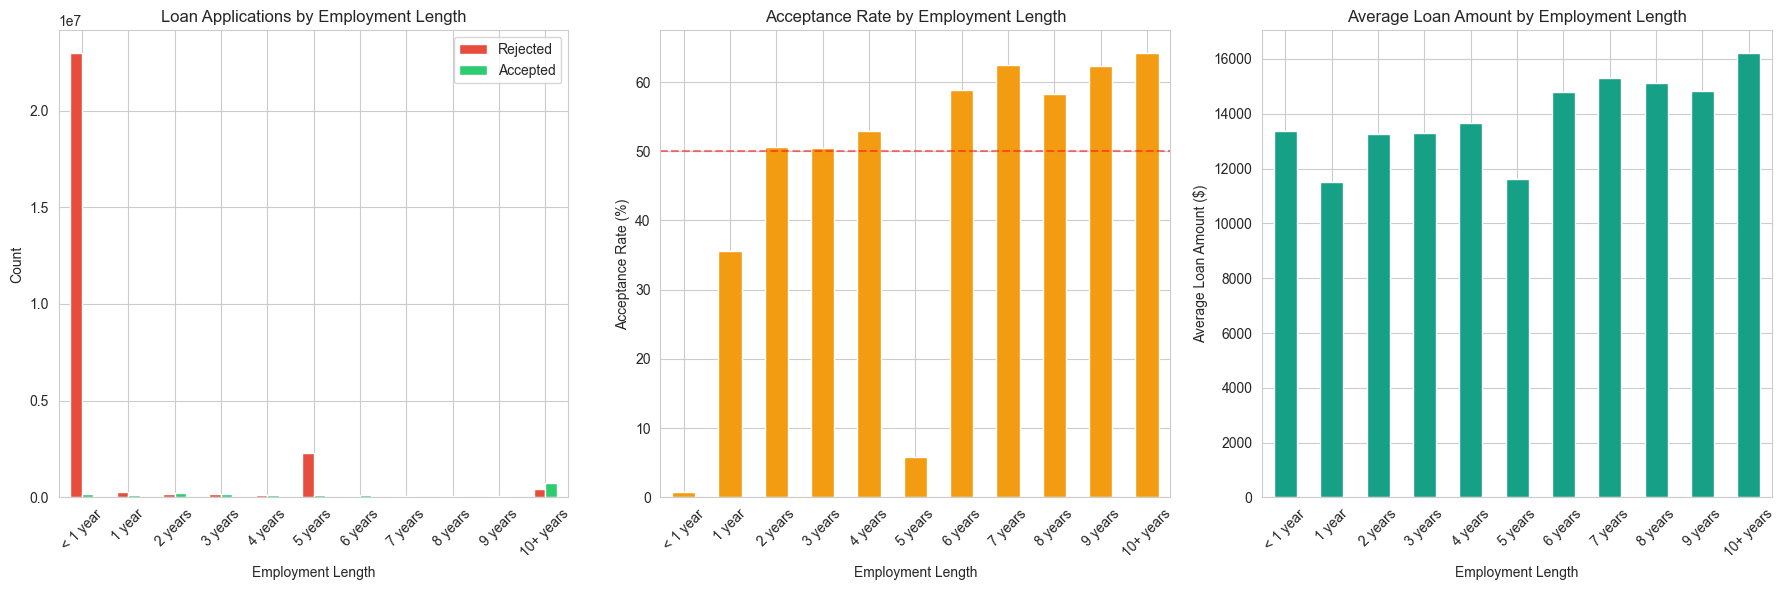

In [13]:
print("\n" + "=" * 80)
print("EMPLOYMENT LENGTH ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Employment length distribution
emp_counts = combined_df.groupby(['emp_length', 'loan_status']).size().unstack(fill_value=0)
emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
             '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_counts_ordered = emp_counts.reindex([e for e in emp_order if e in emp_counts.index])

emp_counts_ordered.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Loan Applications by Employment Length')
axes[0].set_xlabel('Employment Length')
axes[0].set_ylabel('Count')
axes[0].legend(['Rejected', 'Accepted'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Acceptance rate by employment length
emp_acceptance = pd.crosstab(combined_df['emp_length'], combined_df['loan_status'], normalize='index') * 100
emp_acceptance_ordered = emp_acceptance.reindex([e for e in emp_order if e in emp_acceptance.index])
emp_acceptance_ordered[1].plot(kind='bar', ax=axes[1], color='#f39c12')
axes[1].set_title('Acceptance Rate by Employment Length')
axes[1].set_xlabel('Employment Length')
axes[1].set_ylabel('Acceptance Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5)

# Average loan amount by employment length
emp_loan_avg = combined_df.groupby('emp_length')['amount_requested'].mean()
emp_loan_avg_ordered = emp_loan_avg.reindex([e for e in emp_order if e in emp_loan_avg.index])
emp_loan_avg_ordered.plot(kind='bar', ax=axes[2], color='#16a085')
axes[2].set_title('Average Loan Amount by Employment Length')
axes[2].set_xlabel('Employment Length')
axes[2].set_ylabel('Average Loan Amount ($)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


GEOGRAPHIC ANALYSIS


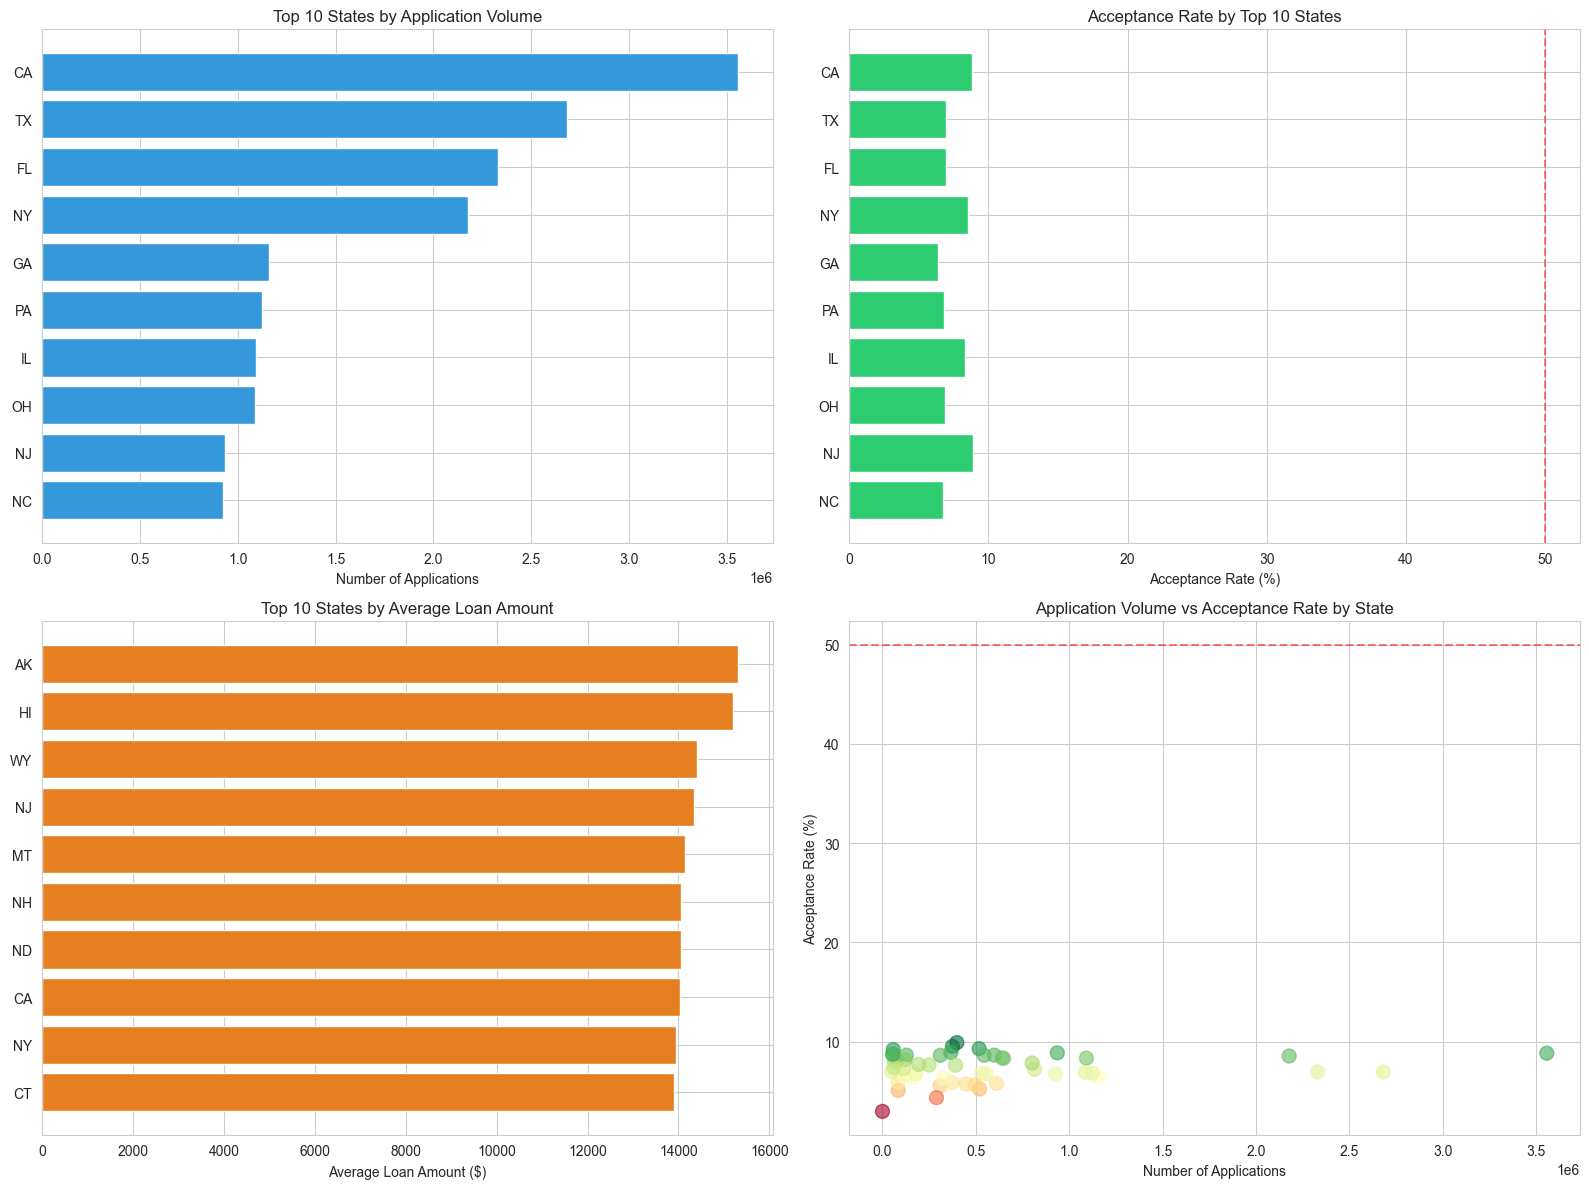


Top 5 States by Volume:
state
CA    3556702
TX    2681846
FL    2329575
NY    2177568
GA    1157810
Name: count, dtype: int64

Top 5 States by Acceptance Rate (min 10 applications):
   state  acceptance_rate   total
23    MN         9.910170  398752
6     CT         9.535115  375297
5     CO         9.298076  518204
7     DC         9.208603   58163
33    NV         8.916928  366236


In [14]:

print("\n" + "=" * 80)
print("GEOGRAPHIC ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top states by volume
top_10_states = combined_df['state'].value_counts().head(10)
axes[0, 0].barh(top_10_states.index, top_10_states.values, color='#3498db')
axes[0, 0].set_xlabel('Number of Applications')
axes[0, 0].set_title('Top 10 States by Application Volume')
axes[0, 0].invert_yaxis()

# Acceptance rate by top states
state_stats = combined_df.groupby('state').agg({
    'loan_status': ['sum', 'count']
}).reset_index()
state_stats.columns = ['state', 'accepted', 'total']
state_stats['acceptance_rate'] = (state_stats['accepted'] / state_stats['total']) * 100
top_states_list = top_10_states.index.tolist()
top_states_acceptance = state_stats[state_stats['state'].isin(top_states_list)].sort_values('total', ascending=True)

axes[0, 1].barh(top_states_acceptance['state'], top_states_acceptance['acceptance_rate'], color='#2ecc71')
axes[0, 1].set_xlabel('Acceptance Rate (%)')
axes[0, 1].set_title('Acceptance Rate by Top 10 States')
axes[0, 1].axvline(50, color='red', linestyle='--', alpha=0.5)

# Average loan amount by state
avg_loan_by_state = combined_df.groupby('state')['amount_requested'].mean().sort_values(ascending=False).head(10)
axes[1, 0].barh(avg_loan_by_state.index, avg_loan_by_state.values, color='#e67e22')
axes[1, 0].set_xlabel('Average Loan Amount ($)')
axes[1, 0].set_title('Top 10 States by Average Loan Amount')
axes[1, 0].invert_yaxis()

# State diversity - applications vs acceptance
state_diversity = state_stats[state_stats['total'] >= 5]  # Filter for meaningful data
axes[1, 1].scatter(state_diversity['total'], state_diversity['acceptance_rate'], 
                   s=100, alpha=0.6, c=state_diversity['acceptance_rate'], cmap='RdYlGn')
axes[1, 1].set_xlabel('Number of Applications')
axes[1, 1].set_ylabel('Acceptance Rate (%)')
axes[1, 1].set_title('Application Volume vs Acceptance Rate by State')
axes[1, 1].axhline(50, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nTop 5 States by Volume:")
print(top_10_states.head())
print("\nTop 5 States by Acceptance Rate (min 10 applications):")
high_volume_states = state_stats[state_stats['total'] >= 10].sort_values('acceptance_rate', ascending=False)
print(high_volume_states[['state', 'acceptance_rate', 'total']].head())


MULTI-FEATURE INTERACTION ANALYSIS


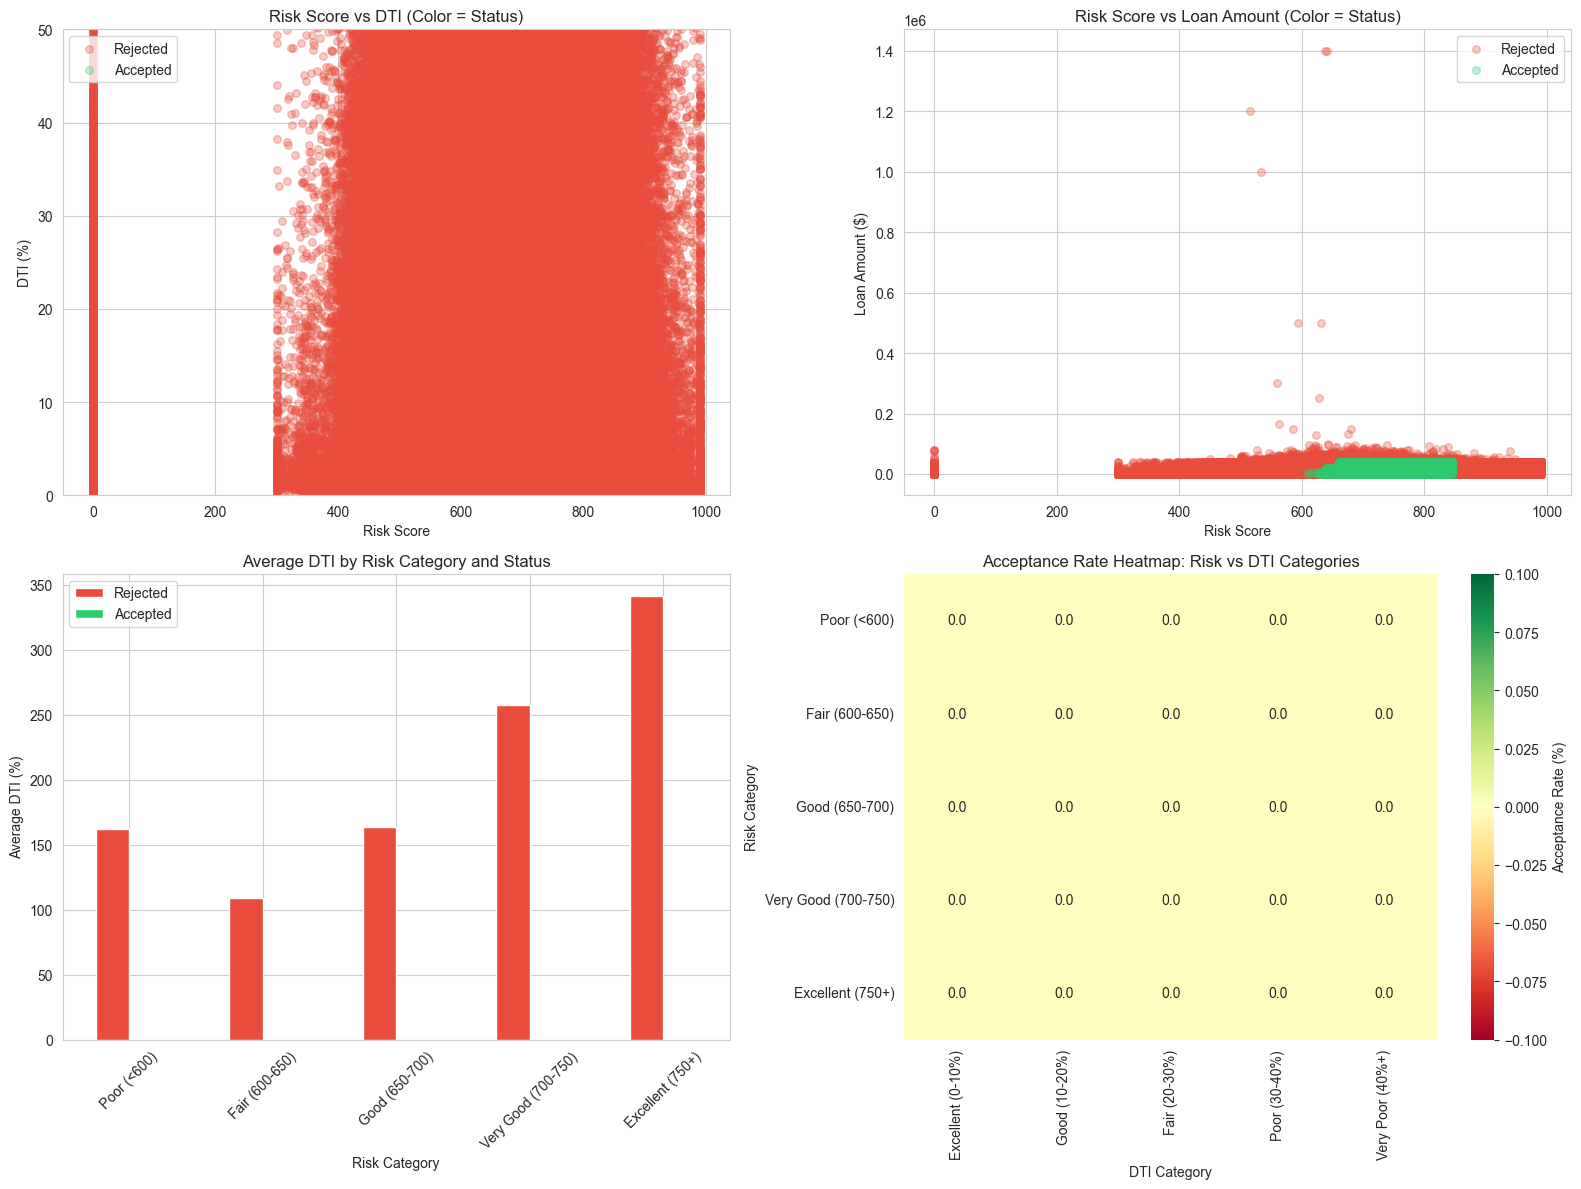

In [15]:
print("\n" + "=" * 80)
print("MULTI-FEATURE INTERACTION ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk Score + DTI interaction
for status, color, label in [(0, '#e74c3c', 'Rejected'), (1, '#2ecc71', 'Accepted')]:
    data = combined_df[combined_df['loan_status'] == status]
    axes[0, 0].scatter(data['risk_score'], data['dti_clean'], 
                       alpha=0.3, s=30, c=color, label=label)
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('DTI (%)')
axes[0, 0].set_title('Risk Score vs DTI (Color = Status)')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 50)

# Amount + Risk Score interaction
for status, color, label in [(0, '#e74c3c', 'Rejected'), (1, '#2ecc71', 'Accepted')]:
    data = combined_df[combined_df['loan_status'] == status]
    axes[0, 1].scatter(data['risk_score'], data['amount_requested'], 
                       alpha=0.3, s=30, c=color, label=label)
axes[0, 1].set_xlabel('Risk Score')
axes[0, 1].set_ylabel('Loan Amount ($)')
axes[0, 1].set_title('Risk Score vs Loan Amount (Color = Status)')
axes[0, 1].legend()

# Risk categories with average DTI
risk_dti = combined_df.groupby(['risk_category', 'loan_status'])['dti_clean'].mean().unstack()
risk_dti.plot(kind='bar', ax=axes[1, 0], color=['#e74c3c', '#2ecc71'])
axes[1, 0].set_title('Average DTI by Risk Category and Status')
axes[1, 0].set_xlabel('Risk Category')
axes[1, 0].set_ylabel('Average DTI (%)')
axes[1, 0].legend(['Rejected', 'Accepted'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# Loan amount distribution by risk and DTI categories
pivot_data = combined_df.groupby(['risk_category', 'dti_category'])['loan_status'].mean() * 100
pivot_data = pivot_data.unstack(fill_value=0)
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1, 1], 
            cbar_kws={'label': 'Acceptance Rate (%)'})
axes[1, 1].set_title('Acceptance Rate Heatmap: Risk vs DTI Categories')
axes[1, 1].set_xlabel('DTI Category')
axes[1, 1].set_ylabel('Risk Category')

plt.tight_layout()
plt.show()


OUTLIER DETECTION AND ANALYSIS


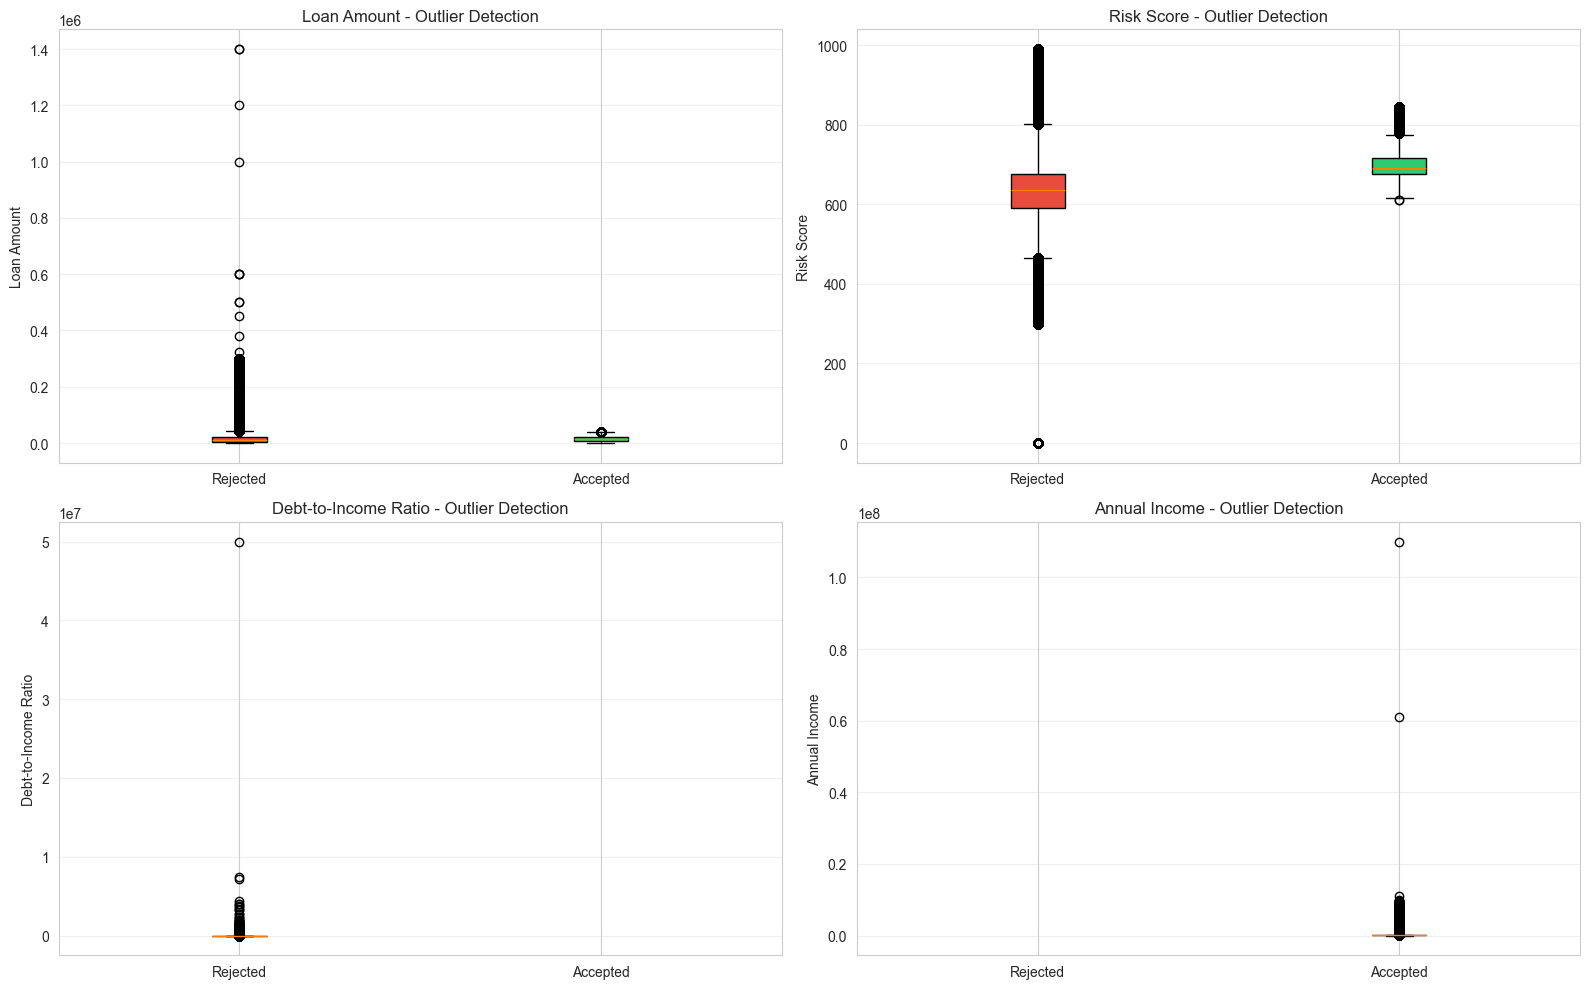


Outlier Statistics (using IQR method):

amount_requested:
  Total outliers: 178627 (0.60%)
  Outlier range: < -17500.00 or > 42500.00

risk_score:
  Total outliers: 204245 (0.68%)
  Outlier range: < 479.00 or > 815.00

dti_clean:
  Total outliers: 2417316 (8.08%)
  Outlier range: < -34.76 or > 79.44


In [16]:
print("\n" + "=" * 80)
print("OUTLIER DETECTION AND ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Box plots for outlier detection
features_outlier = ['amount_requested', 'risk_score', 'dti_clean', 'annual_inc']
titles = ['Loan Amount', 'Risk Score', 'Debt-to-Income Ratio', 'Annual Income']

for idx, (feature, title) in enumerate(zip(features_outlier, titles)):
    if feature in combined_df.columns:
        data_to_plot = [
            combined_df[combined_df['loan_status']==0][feature].dropna(),
            combined_df[combined_df['loan_status']==1][feature].dropna()
        ]
        bp = axes.ravel()[idx].boxplot(data_to_plot, labels=['Rejected', 'Accepted'],
                                        patch_artist=True)
        for patch, color in zip(bp['boxes'], ['#e74c3c', '#2ecc71']):
            patch.set_facecolor(color)
        axes.ravel()[idx].set_title(f'{title} - Outlier Detection')
        axes.ravel()[idx].set_ylabel(title)
        axes.ravel()[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Outlier statistics
print("\nOutlier Statistics (using IQR method):")
for feature in ['amount_requested', 'risk_score', 'dti_clean']:
    if feature in combined_df.columns:
        Q1 = combined_df[feature].quantile(0.25)
        Q3 = combined_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = combined_df[(combined_df[feature] < Q1 - 1.5*IQR) | 
                               (combined_df[feature] > Q3 + 1.5*IQR)]
        print(f"\n{feature}:")
        print(f"  Total outliers: {len(outliers)} ({len(outliers)/len(combined_df)*100:.2f}%)")
        print(f"  Outlier range: < {Q1 - 1.5*IQR:.2f} or > {Q3 + 1.5*IQR:.2f}")



COMPREHENSIVE SUMMARY STATISTICS

Comparative Statistics Table:
      Feature  Accepted_Mean  Rejected_Mean  Accepted_Median  Rejected_Median  Mean_Difference  Median_Difference
  Loan Amount   15046.931228   13133.240309          12900.0         10000.00      1913.690919             2900.0
   Risk Score     698.588205     628.172090            690.0           637.00        70.416115               53.0
          DTI            NaN     143.340051              NaN            19.98              NaN                NaN
Annual Income   77992.428687            NaN          65000.0              NaN              NaN                NaN


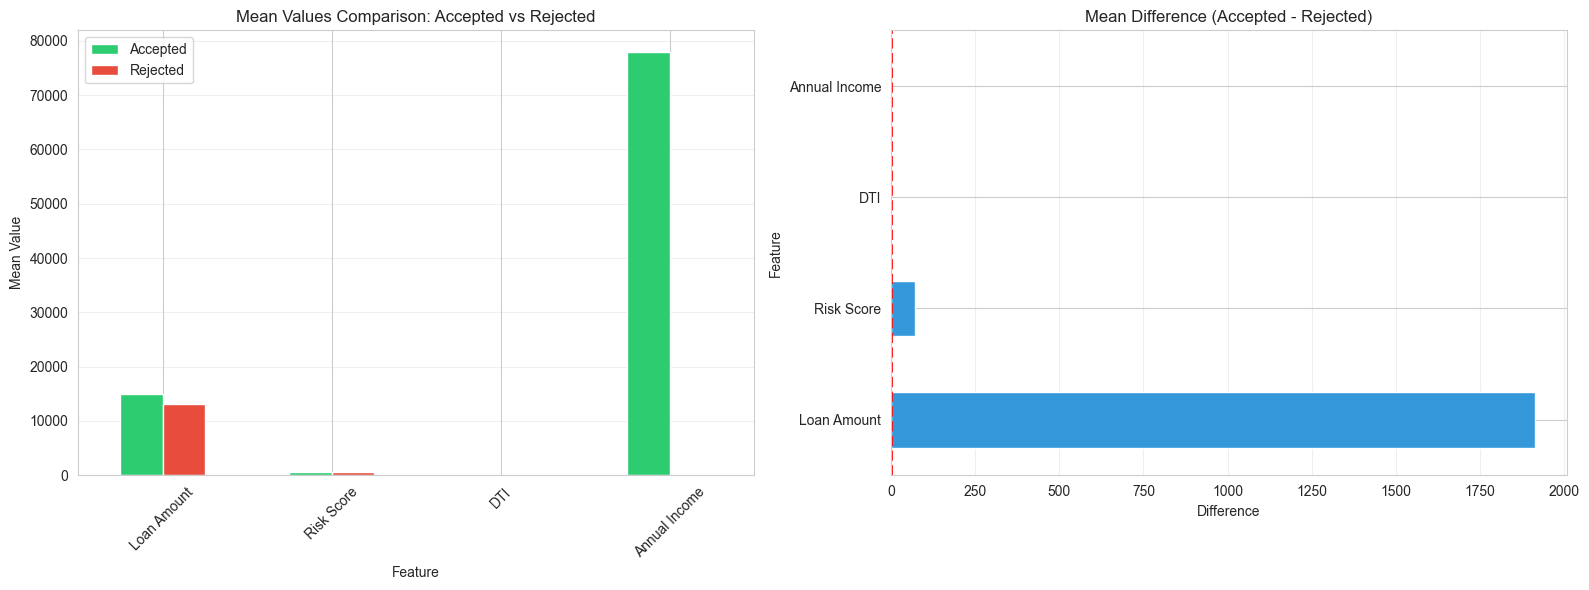


EXTENDED EDA COMPLETED!


In [17]:
print("\n" + "=" * 80)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("=" * 80)

summary_stats = pd.DataFrame({
    'Feature': ['Loan Amount', 'Risk Score', 'DTI', 'Annual Income'],
    'Accepted_Mean': [
        combined_df[combined_df['loan_status']==1]['amount_requested'].mean(),
        combined_df[combined_df['loan_status']==1]['risk_score'].mean(),
        combined_df[combined_df['loan_status']==1]['dti_clean'].mean(),
        combined_df[combined_df['loan_status']==1]['annual_inc'].mean()
    ],
    'Rejected_Mean': [
        combined_df[combined_df['loan_status']==0]['amount_requested'].mean(),
        combined_df[combined_df['loan_status']==0]['risk_score'].mean(),
        combined_df[combined_df['loan_status']==0]['dti_clean'].mean(),
        combined_df[combined_df['loan_status']==0]['annual_inc'].mean()
    ],
    'Accepted_Median': [
        combined_df[combined_df['loan_status']==1]['amount_requested'].median(),
        combined_df[combined_df['loan_status']==1]['risk_score'].median(),
        combined_df[combined_df['loan_status']==1]['dti_clean'].median(),
        combined_df[combined_df['loan_status']==1]['annual_inc'].median()
    ],
    'Rejected_Median': [
        combined_df[combined_df['loan_status']==0]['amount_requested'].median(),
        combined_df[combined_df['loan_status']==0]['risk_score'].median(),
        combined_df[combined_df['loan_status']==0]['dti_clean'].median(),
        combined_df[combined_df['loan_status']==0]['annual_inc'].median()
    ]
})

summary_stats['Mean_Difference'] = summary_stats['Accepted_Mean'] - summary_stats['Rejected_Mean']
summary_stats['Median_Difference'] = summary_stats['Accepted_Median'] - summary_stats['Rejected_Median']

print("\nComparative Statistics Table:")
print(summary_stats.to_string(index=False))

# Visualize differences
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean comparison
summary_stats_plot = summary_stats.set_index('Feature')[['Accepted_Mean', 'Rejected_Mean']]
summary_stats_plot.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Mean Values Comparison: Accepted vs Rejected')
axes[0].set_ylabel('Mean Value')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(['Accepted', 'Rejected'])
axes[0].grid(axis='y', alpha=0.3)

# Difference visualization
summary_stats.set_index('Feature')['Mean_Difference'].plot(kind='barh', ax=axes[1], color='#3498db')
axes[1].set_title('Mean Difference (Accepted - Rejected)')
axes[1].set_xlabel('Difference')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("EXTENDED EDA COMPLETED!")
print("=" * 80)


In [18]:
print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Create a copy for modeling
model_df = combined_df.copy()

# Handle DTI (convert percentage string to float)
if model_df['dti'].dtype == 'object':
    model_df['dti'] = model_df['dti'].str.rstrip('%').astype('float')

# Handle employment length
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
model_df['emp_length_numeric'] = model_df['emp_length'].map(emp_length_map)

# Encode state
le_state = LabelEncoder()
model_df['state_encoded'] = le_state.fit_transform(model_df['state'].astype(str))

# Select features for modeling
feature_cols = ['amount_requested', 'risk_score', 'dti', 'emp_length_numeric', 'state_encoded']
X = model_df[feature_cols].copy()
y = model_df['loan_status']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

print(f"\nFeatures selected: {feature_cols}")
print(f"Feature matrix shape: {X_imputed.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nMissing values after imputation: {X_imputed.isnull().sum().sum()}")


DATA PREPROCESSING

Features selected: ['amount_requested', 'risk_score', 'dti', 'emp_length_numeric', 'state_encoded']
Feature matrix shape: (29909442, 5)
Target vector shape: (29909442,)

Missing values after imputation: 0


In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData scaling completed!")


Training set size: 23927553
Test set size: 5981889

Data scaling completed!


In [20]:
print("\n" + "=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall: {recall_score(y_test, lr_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")


MODEL 1: LOGISTIC REGRESSION

Accuracy: 0.9440
Precision: 0.6917
Recall: 0.4680
F1-Score: 0.5582
ROC-AUC: 0.9473


In [24]:
print("\n" + "=" * 80)
print("MODEL 3: GRADIENT BOOSTING")
print("=" * 80)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test, gb_pred):.4f}")
print(f"Precision: {precision_score(y_test, gb_pred):.4f}")
print(f"Recall: {recall_score(y_test, gb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, gb_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, gb_pred_proba):.4f}")


MODEL 3: GRADIENT BOOSTING

Accuracy: 1.0000
Precision: 0.9997
Recall: 0.9999
F1-Score: 0.9998
ROC-AUC: 1.0000


In [25]:
print("\n" + "=" * 80)
print("MODEL 4: DECISION TREE")
print("=" * 80)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test, dt_pred):.4f}")
print(f"Precision: {precision_score(y_test, dt_pred):.4f}")
print(f"Recall: {recall_score(y_test, dt_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, dt_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_pred_proba):.4f}")


MODEL 4: DECISION TREE

Accuracy: 1.0000
Precision: 0.9998
Recall: 0.9999
F1-Score: 0.9998
ROC-AUC: 1.0000



MODEL COMPARISON SUMMARY
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.944018   0.691658  0.467959  0.558232  0.947269
1    Gradient Boosting  0.999972   0.999737  0.999896  0.999816  0.999997
2        Decision Tree  0.999977   0.999768  0.999927  0.999847  0.999991


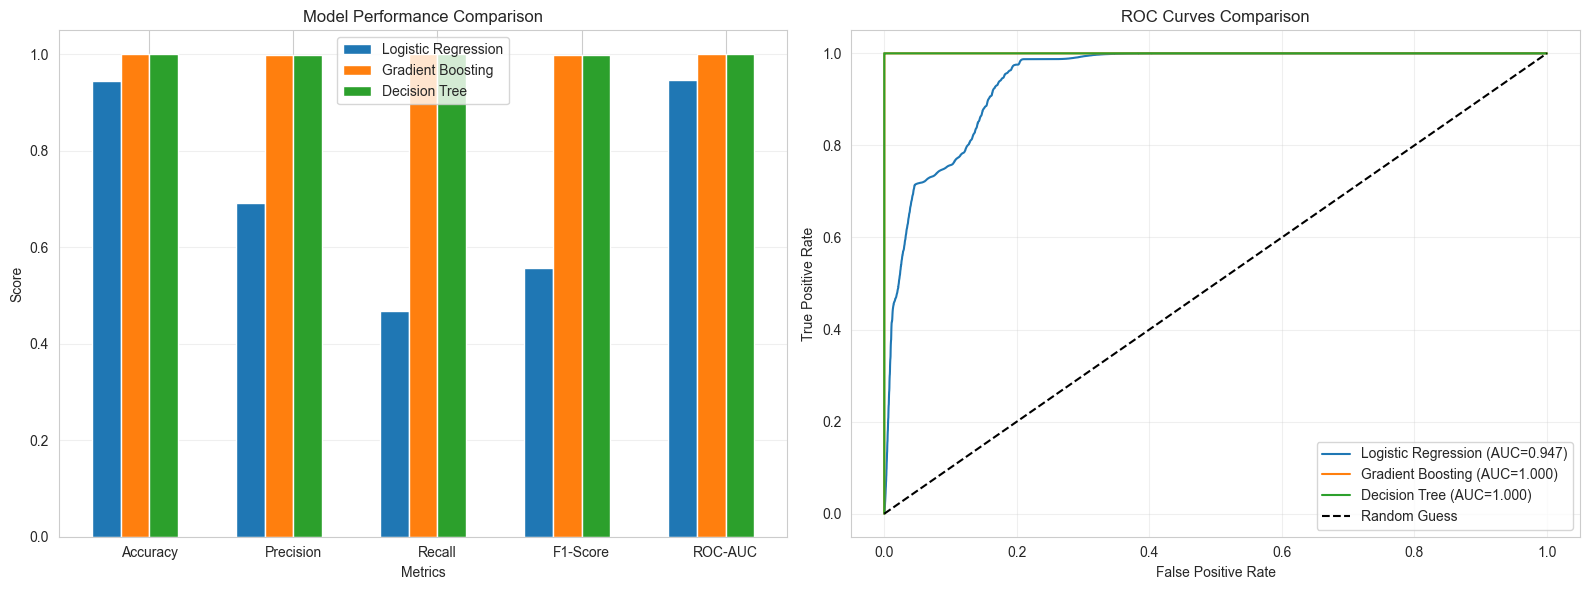

In [28]:
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Gradient Boosting', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, gb_pred),
        accuracy_score(y_test, dt_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, gb_pred),
        precision_score(y_test, dt_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, gb_pred),
        recall_score(y_test, dt_pred)
    ],
    'F1-Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, gb_pred),
        f1_score(y_test, dt_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, lr_pred_proba),
        roc_auc_score(y_test, gb_pred_proba),
        roc_auc_score(y_test, dt_pred_proba)
    ]
})

print(models_comparison)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

for idx, model in enumerate(models_comparison['Model']):
    values = models_comparison.iloc[idx, 1:].values
    axes[0].bar(x + idx*width, values, width, label=model)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pred_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred_proba)

axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_pred_proba):.3f})')
axes[1].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_score(y_test, gb_pred_proba):.3f})')
axes[1].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={roc_auc_score(y_test, dt_pred_proba):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Best Model: Decision Tree


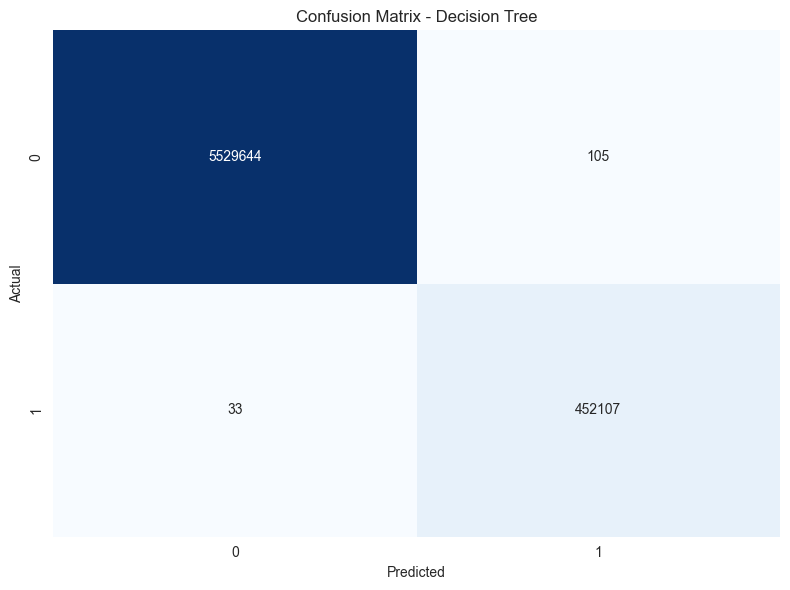


Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00   5529749
    Accepted       1.00      1.00      1.00    452140

    accuracy                           1.00   5981889
   macro avg       1.00      1.00      1.00   5981889
weighted avg       1.00      1.00      1.00   5981889



In [29]:

best_model_idx = models_comparison['F1-Score'].idxmax()
best_model_name = models_comparison.iloc[best_model_idx]['Model']

print(f"\nBest Model: {best_model_name}")

# Get predictions from best model
if best_model_name == 'Random Forest':
    best_pred = rf_pred
elif best_model_name == 'Gradient Boosting':
    best_pred = gb_pred
elif best_model_name == 'Decision Tree':
    best_pred = dt_pred
else:
    best_pred = lr_pred

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=['Rejected', 'Accepted']))

In [32]:
print("\n" + "=" * 80)
print("GENERATING TEST DATA FOR PREDICTIONS")
print("=" * 80)

# Create realistic test cases
test_cases = pd.DataFrame({
    'amount_requested': [5000, 15000, 25000, 8000, 12000, 30000, 3500, 20000],
    'risk_score': [720, 680, 750, 620, 700, 660, 740, 690],
    'dti': [15.5, 22.3, 8.7, 35.2, 18.9, 28.5, 12.1, 25.0],
    'emp_length_numeric': [5, 10, 3, 1, 7, 10, 2, 6],
    'state_encoded': [10, 5, 20, 15, 8, 12, 18, 7]
})

# Add description
test_cases['description'] = [
    'Medium loan, good credit, low DTI',
    'Large loan, fair credit, moderate DTI',
    'Large loan, excellent credit, low DTI',
    'Small loan, poor credit, high DTI',
    'Medium loan, good credit, moderate DTI',
    'Very large loan, fair credit, high DTI',
    'Small loan, excellent credit, low DTI',
    'Large loan, good credit, moderate DTI'
]

print("\nTest Cases:")
print(test_cases)

# Make predictions with all models
test_cases['LR_Prediction'] = lr_model.predict(scaler.transform(test_cases[feature_cols]))
test_cases['GB_Prediction'] = gb_model.predict(test_cases[feature_cols])
test_cases['DT_Prediction'] = dt_model.predict(test_cases[feature_cols])

# Get probabilities
test_cases['LR_Prob_Accepted'] = lr_model.predict_proba(scaler.transform(test_cases[feature_cols]))[:, 1]
test_cases['GB_Prob_Accepted'] = gb_model.predict_proba(test_cases[feature_cols])[:, 1]
test_cases['DT_Prob_Accepted'] = dt_model.predict_proba(test_cases[feature_cols])[:, 1]

# Display predictions
print("\n" + "=" * 80)
print("PREDICTIONS ON TEST CASES")
print("=" * 80)

for idx, row in test_cases.iterrows():
    print(f"\nTest Case {idx + 1}: {row['description']}")
    print(f"  Amount: ${row['amount_requested']:,.0f}")
    print(f"  Risk Score: {row['risk_score']:.0f}")
    print(f"  DTI: {row['dti']:.1f}%")
    print(f"  Employment Length: {row['emp_length_numeric']} years")
    print(f"\n  Predictions:")
    print(f"    Logistic Regression: {'ACCEPTED' if row['LR_Prediction']<=1 else 'REJECTED'} ({row['LR_Prob_Accepted']:.2%} confidence)")
    print(f"    Gradient Boosting: {'ACCEPTED' if row['GB_Prediction']==1 else 'REJECTED'} ({row['GB_Prob_Accepted']:.2%} confidence)")
    print(f"    Decision Tree: {'ACCEPTED' if row['DT_Prediction']==1 else 'REJECTED'} ({row['DT_Prob_Accepted']:.2%} confidence)")


GENERATING TEST DATA FOR PREDICTIONS

Test Cases:
   amount_requested  risk_score   dti  emp_length_numeric  state_encoded  \
0              5000         720  15.5                   5             10   
1             15000         680  22.3                  10              5   
2             25000         750   8.7                   3             20   
3              8000         620  35.2                   1             15   
4             12000         700  18.9                   7              8   
5             30000         660  28.5                  10             12   
6              3500         740  12.1                   2             18   
7             20000         690  25.0                   6              7   

                              description  
0       Medium loan, good credit, low DTI  
1   Large loan, fair credit, moderate DTI  
2   Large loan, excellent credit, low DTI  
3       Small loan, poor credit, high DTI  
4  Medium loan, good credit, moderate DTI  
